## 🧭 Urban Morphology Workflow – Phú Quốc City
🔧 Starter Jupyter Notebook – What It Will Include:
#### ✅ Part 1: Download and Load Spatial Data
Use osmnx to download building footprints and street network from OpenStreetMap for Phu Quoc.
#### ✅ Part 2: Morphological Analysis
Using momepy:
- Compute building area, compactness, elongation
- Analyze street orientation and entropy
- Calculate block-level metrics (optional, if available)
#### ✅ Part 3: Visualization
- Plot spatial distribution of indicators (e.g., choropleth)
- Overlay on basemaps with contextily

### 📦 Initial: Import required packages and configure OSMnx

In [8]:
# 📦 Import required packages
# This notebook downloads building footprints and the street network for Phú Quốc, computes morphological metrics (area, compactness, elongation) using momepy, 
# and analyzes street orientation entropy.

# %%
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import contextily as cx
from pyproj import CRS
import numpy as np

### ✅ Part 1: Download and Load Spatial Data
Use osmnx to download building footprints and street network from OpenStreetMap for Phu Quoc.

In [3]:
# Define the study area
place_name = "Phu Quoc, Kien Giang, Vietnam"

# Download building footprints using the latest API function
tags = {"building": True}
buildings = ox.features_from_place(place_name, tags=tags)

In [4]:
# Keep only polygon geometries (Polygon and MultiPolygon)
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = buildings.reset_index(drop=True)

# Add a unique ID column for reference
buildings["uid"] = range(len(buildings))

# For further analysis, retain only the necessary columns
gdf_buildings = buildings[["uid", "geometry"]].copy()


### 2. Project to an Appropriate UTM CRS
 We define a helper function that calculates a UTM CRS based on the centroid of the dataset.


In [ ]:
# %%
def get_utm_crs(gdf):
    centroid = gdf.geometry.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    utm_zone = int((lon + 180) / 6) + 1
    # For the northern hemisphere; Southern flag is False if lat>=0.
    return CRS.from_dict({"proj": "utm", "zone": utm_zone, "south": lat < 0})

utm_crs = get_utm_crs(gdf_buildings)
gdf_buildings = gdf_buildings.to_crs(utm_crs)

# %%
# Save the current CRS for later use
crs = gdf_buildings.crs

### 3. Compute Morphological Metrics with momepy
We compute:
 - **Area:** directly from the geometry.
 - **Compactness:** as area / convex hull area.
 - **Elongation:** ratio of the longer to the shorter side of the minimum rotated rectangle.


In [9]:
# %%
# Compute area (in m²)
gdf_buildings["area"] = gdf_buildings.geometry.area

# Compute compactness: area divided by convex hull area.
gdf_buildings["convex_hull_area"] = gdf_buildings.geometry.convex_hull.area
gdf_buildings["compactness"] = gdf_buildings["area"] / gdf_buildings["convex_hull_area"]

# Define a function to compute elongation based on the minimum rotated rectangle
def calculate_elongation(geom):
    try:
        rect = geom.minimum_rotated_rectangle
        # Get the coordinates of the rectangle; for a rectangle it returns 5 points (first == last)
        coords = list(rect.exterior.coords)
        # Calculate the lengths of each edge
        lengths = []
        for i in range(len(coords)-1):
            dx = coords[i+1][0] - coords[i][0]
            dy = coords[i+1][1] - coords[i][1]
            lengths.append(np.hypot(dx, dy))
        if len(lengths) < 2 or min(lengths) == 0:
            return np.nan
        return max(lengths) / min(lengths)
    except Exception:
        return np.nan

gdf_buildings["elongation"] = gdf_buildings.geometry.apply(calculate_elongation)


### 5. Visualization of Morphological Metrics
We display three maps side‑by‑side showing the calculated metrics: area, compactness, and elongation.


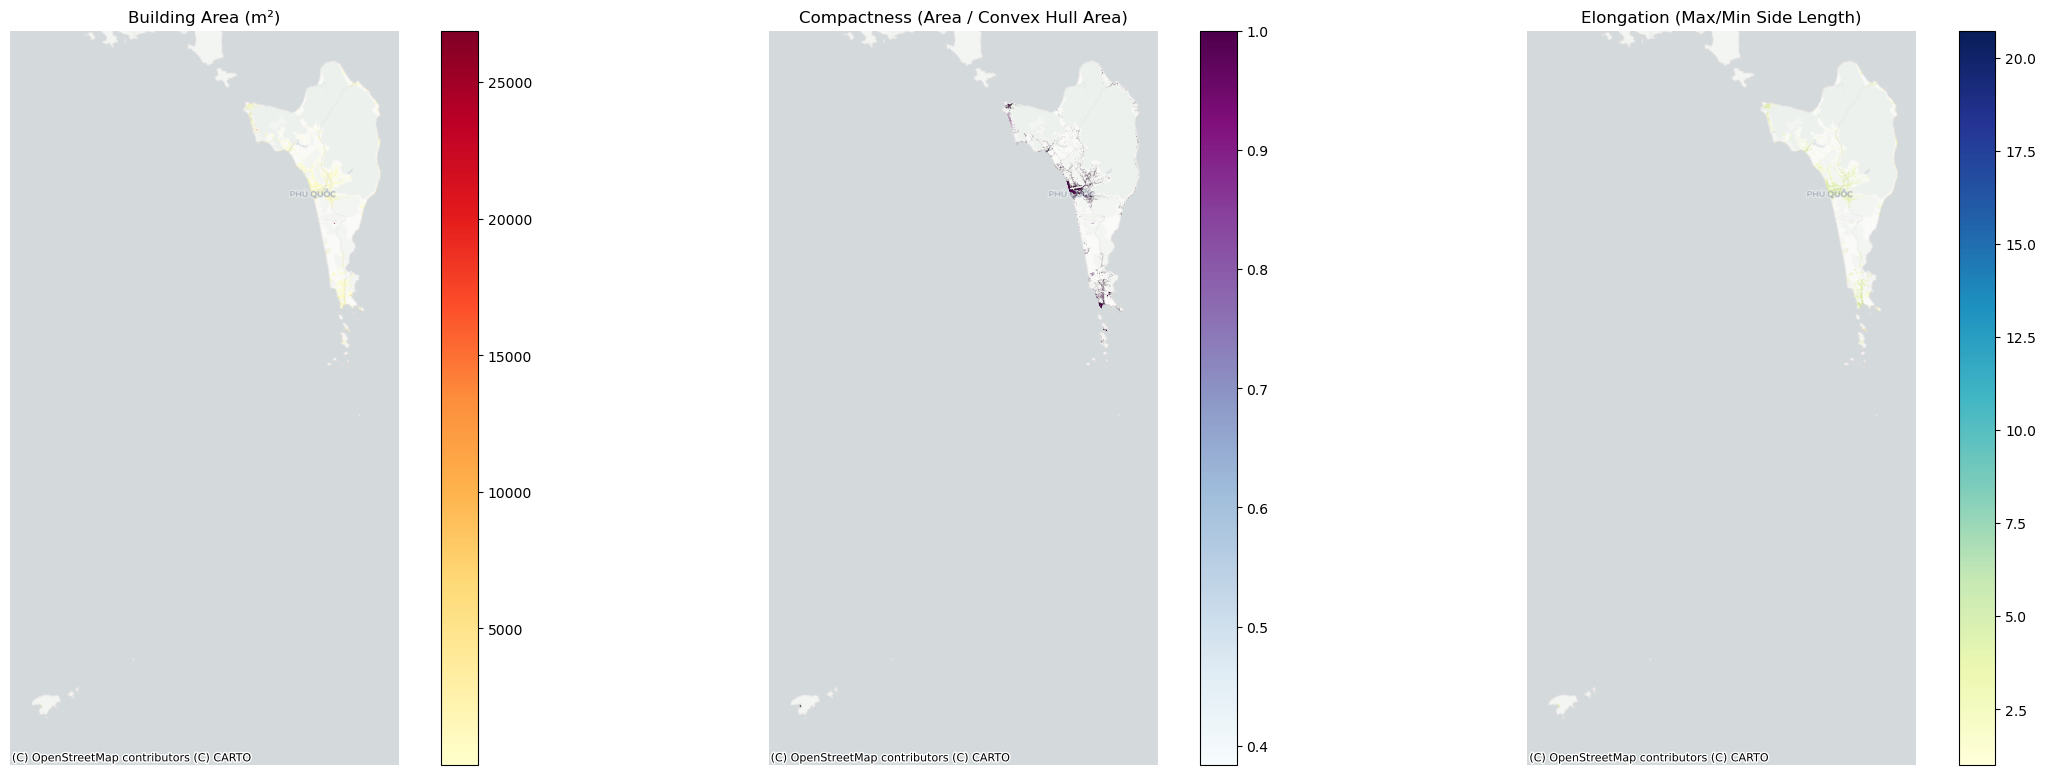

In [20]:
# %%
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Map 1: Building Area
gdf_buildings.plot(column="area", ax=ax[0], cmap="YlOrRd", legend=True)
ax[0].set_title("Building Area (m²)")
cx.add_basemap(ax[0], source=cx.providers.CartoDB.Positron, crs=crs)

# Map 2: Compactness
gdf_buildings.plot(column="compactness", ax=ax[1], cmap="BuPu", legend=True)
ax[1].set_title("Compactness (Area / Convex Hull Area)")
cx.add_basemap(ax[1], source=cx.providers.CartoDB.Positron, crs=crs)

# Map 3: Elongation
gdf_buildings.plot(column="elongation", ax=ax[2], cmap="YlGnBu", legend=True)
ax[2].set_title("Elongation (Max/Min Side Length)")
cx.add_basemap(ax[2], source=cx.providers.CartoDB.Positron, crs=crs)

for a in ax:
    a.axis("off")

plt.tight_layout()
plt.show()

### 🧠 What You Get up to now:
**Building-level morphology metrics**: area, compactness, elongation of the building


### 4. Street Orientation Analysis
We download the street network for Phú Quốc, project it to the same CRS, and (optionally) compute an orientation entropy measure.
(Here, we simply download and display the network as an example; for entropy analysis, additional steps are needed.)


In [46]:
# %%
G = ox.graph_from_place(place_name, network_type="drive")
edges = ox.graph_to_gdfs(G, nodes=False)
edges = edges.to_crs(crs)

# For now, we print the number of edges and nodes:
print(f"Number of street edges: {len(edges)}")

Number of street edges: 15774


### 4. Street Orientation Analysis
The regularity of the street network can be quantified by computing the orientation entropy. A low entropy indicates a consistent, grid‑like layout, while a high entropy suggests a more irregular layout.
We use momepy’s Orientation class, specifying 36 bins (each bin ~10°), to compute the entropy.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate orientation in degrees
def calculate_orientation(geometry):
    if geometry.geom_type == 'LineString':
        x_diff = geometry.coords[-1][0] - geometry.coords[0][0]
        y_diff = geometry.coords[-1][1] - geometry.coords[0][1]
        angle = np.arctan2(y_diff, x_diff)
        angle_deg = np.degrees(angle)
        return angle_deg % 180  # Normalize between 0-180 degrees
    else:
        return np.nan

# Apply the function to each geometry in the edges GeoDataFrame
edges['orientation'] = edges.geometry.apply(calculate_orientation)


In [49]:
from scipy.stats import entropy

# Define the number of bins (e.g., 36 bins for 5-degree intervals)
num_bins = 36
bin_edges = np.linspace(0, 180, num_bins + 1)

# Compute the histogram of orientations
orientation_hist, _ = np.histogram(edges['orientation'].dropna(), bins=bin_edges)

# Normalize the histogram to get a probability distribution
orientation_prob = orientation_hist / orientation_hist.sum()

# Compute the entropy
street_entropy = entropy(orientation_prob, base=2)
print(f"Street orientation entropy: {street_entropy:.3f} (0 = perfect grid, higher = more irregular)")

Street orientation entropy: 5.131 (0 = perfect grid, higher = more irregular)


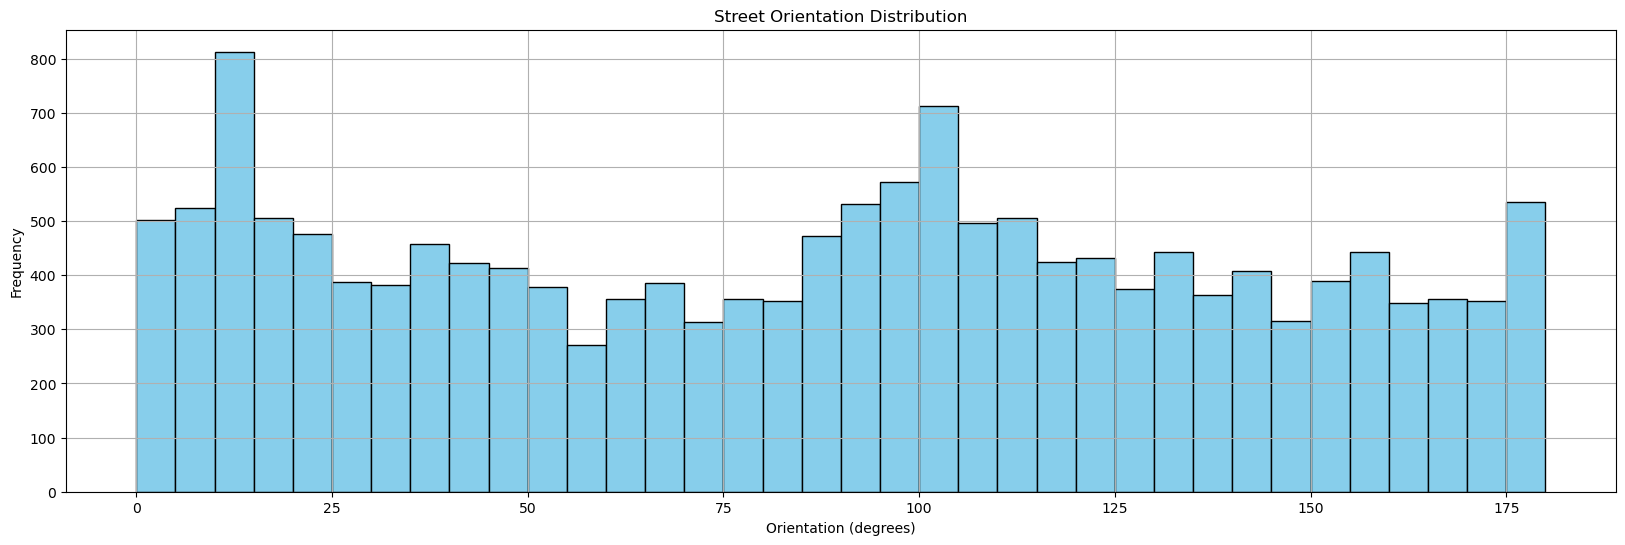

In [50]:
# Plot the orientation histogram
plt.figure(figsize=(20, 6))
plt.hist(edges['orientation'].dropna(), bins=bin_edges, color='skyblue', edgecolor='black')
plt.title('Street Orientation Distribution')
plt.xlabel('Orientation (degrees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()